# Late Fusion: Audio Model Interpretation

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

### Paths

In [3]:
input_path = '../../../2.data_preparation/out/audio/'
output_path = '../out/audio/'
# Global configuration path
glob_conf_path = '../../../config/'

### Load global variables

In [4]:
exec(open(os.path.join(glob_conf_path, 'global_config_paper.py')).read())
exec(open(os.path.join(glob_conf_path, 'config_feature_contributions.py')).read())

## Model interpretation

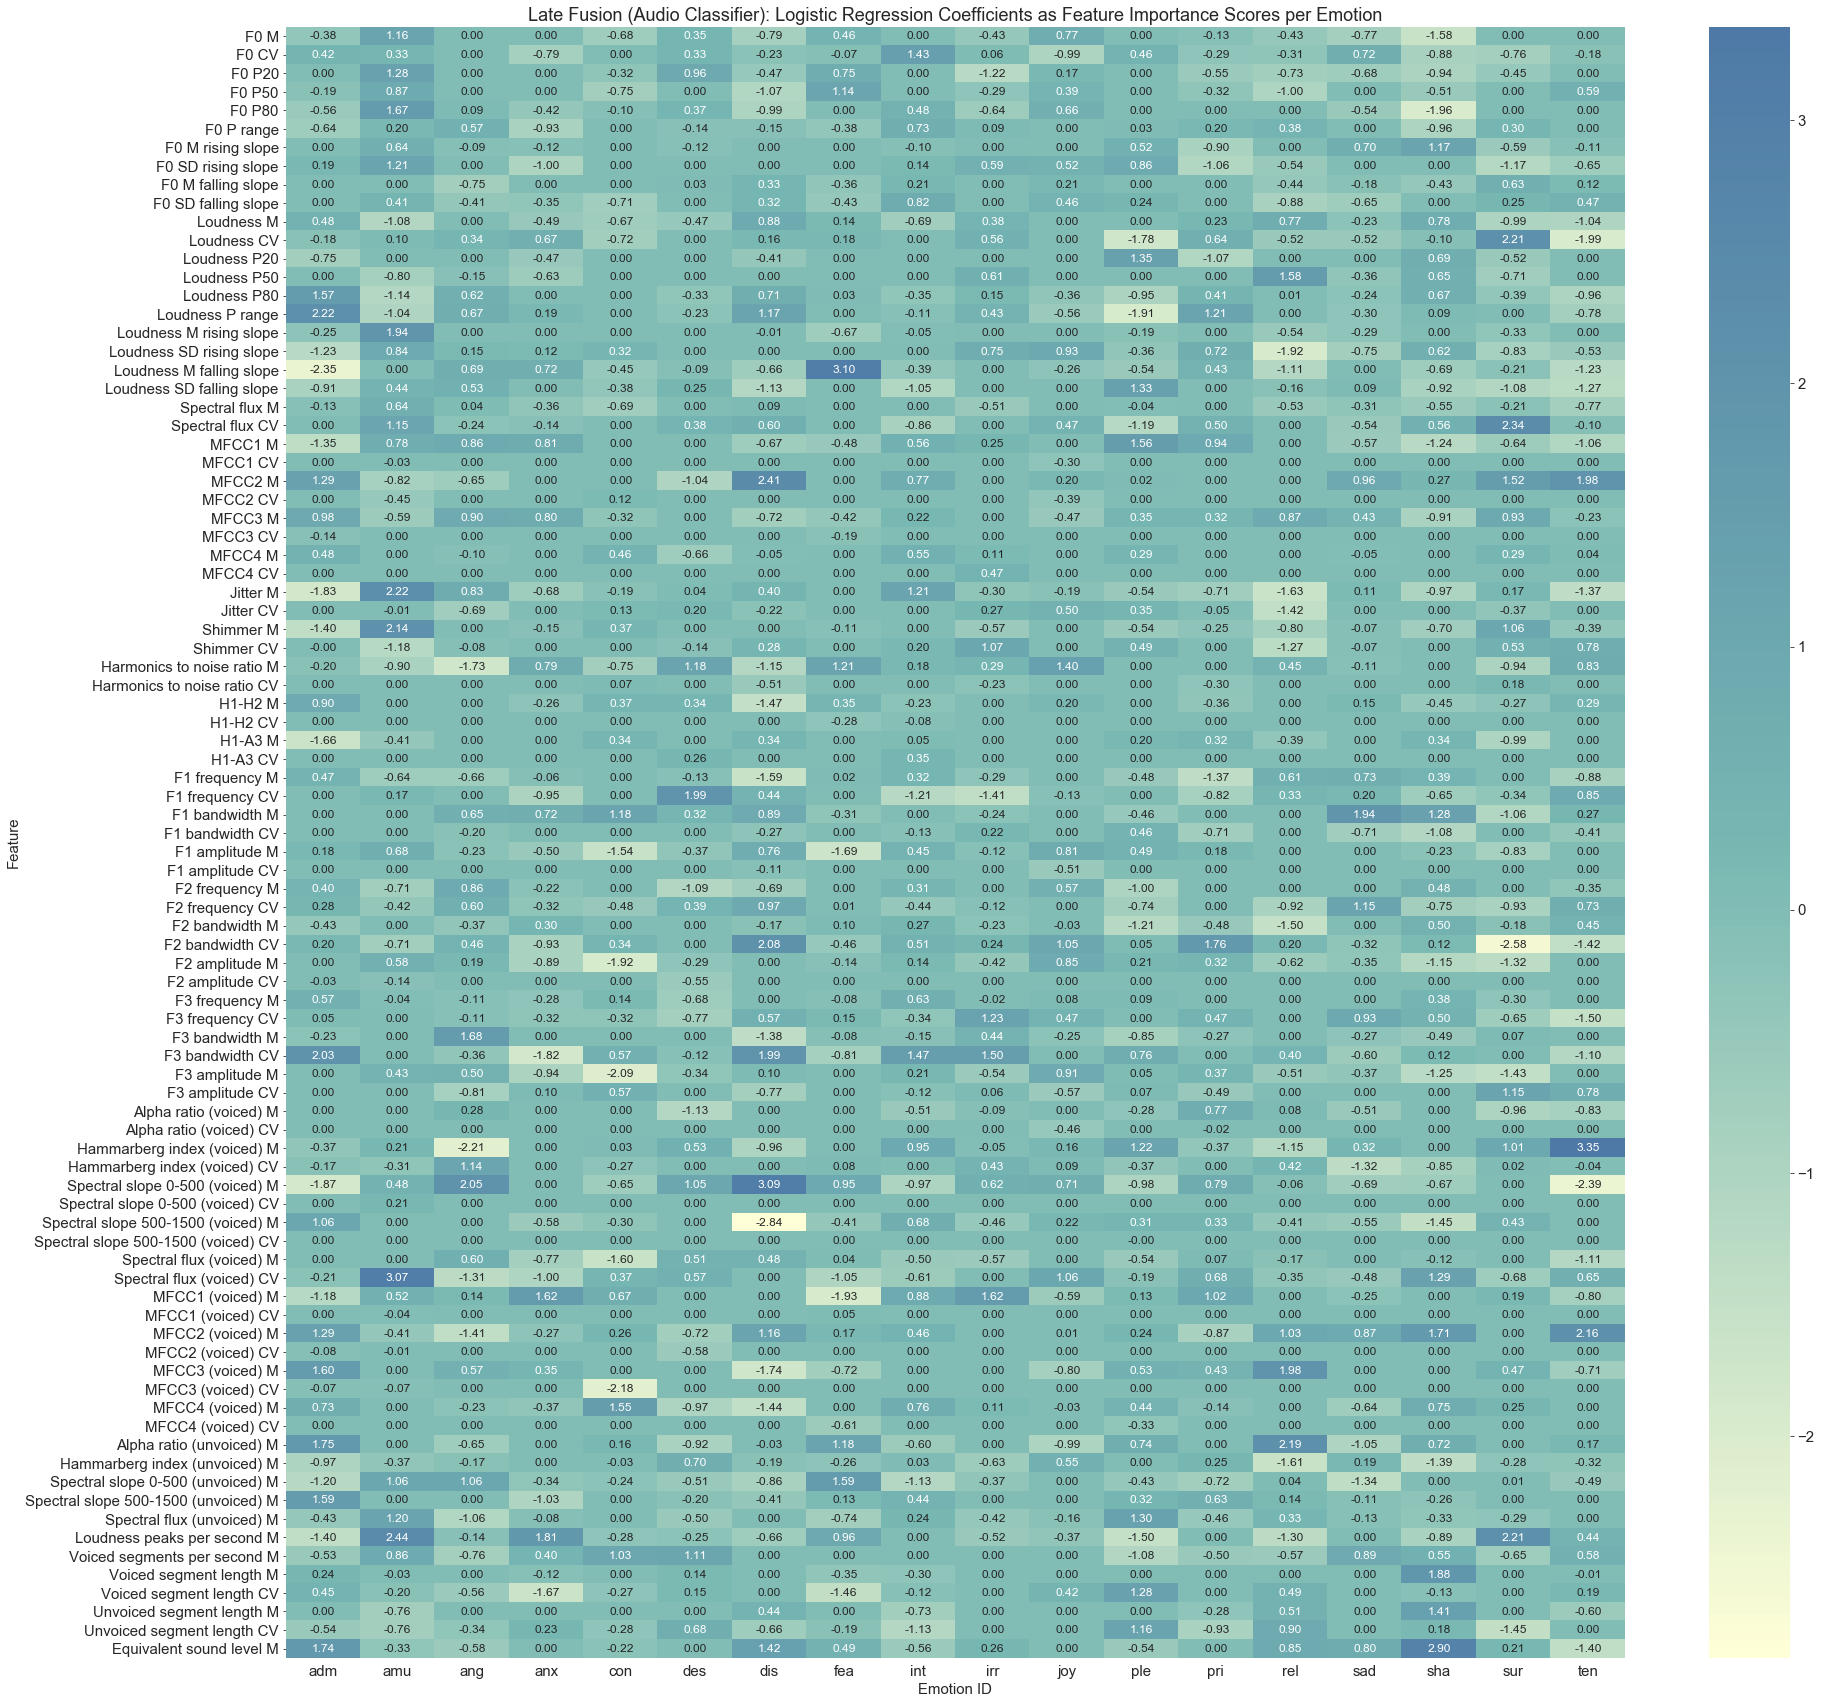

In [5]:
# Load data
train_egemaps_df = pd.read_csv(os.path.join(input_path, 'egemaps', 'audio_data_egemaps_train.csv'))
feat = list(train_egemaps_df.drop(columns=['target','file_id','actor_id','group']).columns)


# Load the model from disk
file_path = os.path.join(output_path,'models','mod_elastic_net_egemaps_audio.sav')
clf = pickle.load(open(file_path, 'rb'))
coef_df = pd.DataFrame(clf.coef_, index=list(emotion_eng_id_to_emotion_num.keys()), columns=feat).T
coef_df = coef_df.reindex(sorted(coef_df.columns), axis=1)
coef_df = coef_df.rename(var_name_to_feat, axis=0)
coef_df = coef_df.reindex(list(var_name_to_feat.values())).dropna()
coef_df.to_csv(os.path.join(output_path,'others','tmp','audio_classifier_feature_contributions.csv'), index=True, header=True)


# Plot results
sns.set_style({'ytick.left': True})
plt.figure(figsize=(30,30))
sns.heatmap(coef_df, annot=True, annot_kws={"size": 12}, fmt='.2f', cmap=conf_cmap)
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
plt.savefig(os.path.join(output_path,'others','report_audio_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.title('Late Fusion (Audio Classifier): Logistic Regression Coefficients as Feature Importance Scores per Emotion')
plt.savefig(os.path.join(output_path,'others','audio_classifier_feature_contributions.svg'), bbox_inches = 'tight')
plt.show()

sns.set_style({'ytick.left': False})

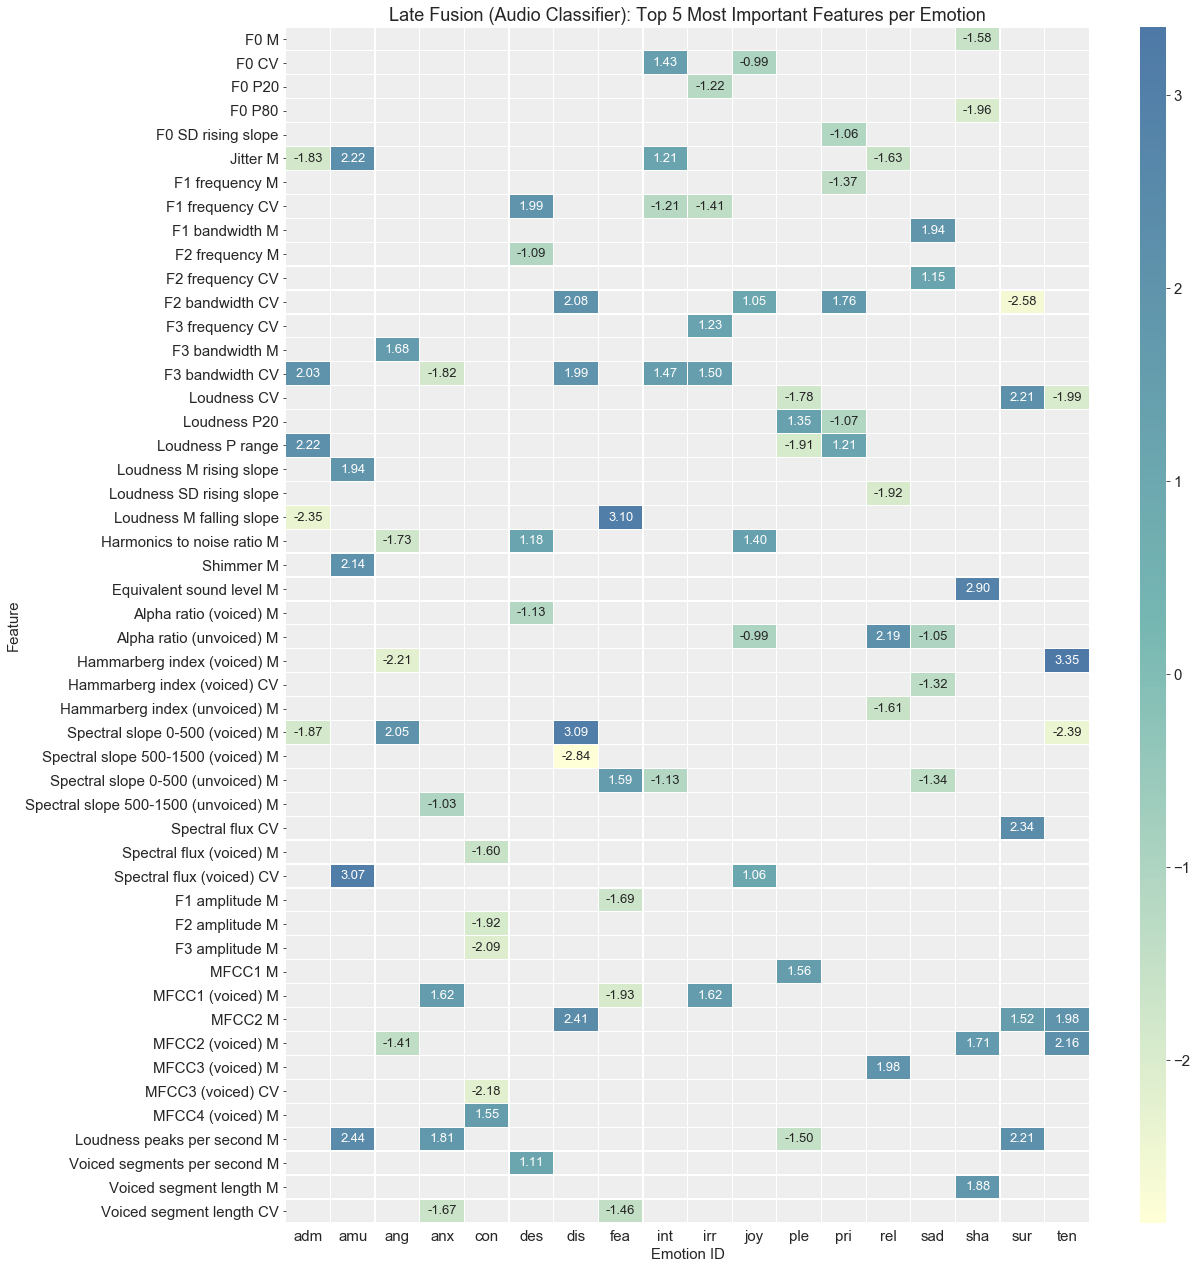

In [6]:
data = coef_df.copy()
data_abs = data.abs()
top_features_per_emotion = {}
n = 5
for c in data.columns:
    top_features_per_emotion[c] = data_abs.nlargest(n, columns=c).index.tolist()

#all_features = set(data.index.tolist())
features_to_keep = set([item for sublist in top_features_per_emotion.values() for item in sublist])
#features_to_drop = all_features - features_to_keep

data_reduced = data.loc[features_to_keep].reindex(data.index).dropna()
data_reduced = data_reduced.reindex(feat_order_summary_audio)
mask = np.array([[feat not in top_features_per_emotion[c] for feat in data_reduced.index] for c in data_reduced.columns]).T
data_reduced.mask(mask).to_csv(os.path.join(output_path,'others','tmp','audio_classifier_feature_contributions_top_'+str(n)+'.csv'), index=True, header=True)

# Plot results
sns.set_style({'ytick.left': True})
plt.figure(figsize=(18,22))
hm = sns.heatmap(data_reduced, annot=True, annot_kws={"size": 13}, fmt='.2f', cmap=conf_cmap, cbar_kws={"aspect": 45}, linewidth=0.25, mask=mask)
plt.xlabel('Emotion ID')
plt.ylabel('Feature')
ax = hm.axes
ax.set_facecolor((238/255, 238/255, 238/255))
plt.savefig(os.path.join(output_path,'others','report_audio_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.title('Late Fusion (Audio Classifier): Top ' + str(n) + ' Most Important Features per Emotion')
plt.savefig(os.path.join(output_path,'others','audio_classifier_feature_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')
plt.show()

sns.set_style({'ytick.left': False})